# Using GCM to handle an example with probabilities

In [305]:
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
from dowhy.utils import plot
from dowhy.gcm.causal_mechanisms import ConditionalStochasticModel
from dowhy.graph import get_ordered_predecessors
import numpy as np
import pandas as pd

### Creating the GCM

#### Setting the DAG

Instead of using a *StructuralCausalModel*, this time we're using a *ProbabilisticCausalModel*. A PCM provides the greatest flexibility in modeling causal mechanisms, as it only requires generating samples conditioned on a node’s parents. Any model that can handle conditional distributions, such as a wide array of Bayesian models, can be employed.

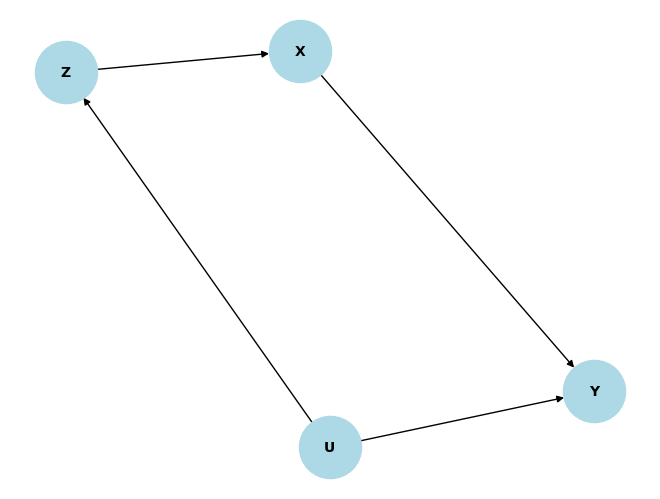

In [306]:
causal_graph = nx.DiGraph([
    ('Z', 'X'),
    ('X', 'Y'),
    ('U', 'Z'),
    ('U', 'Y')
])

causal_model = gcm.ProbabilisticCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

#### Setting the causal mechanisms

In the first example, U is not going to be a latent variable, so data for U will be given and an Empirical Distribution will be the choise for its mechanism.


For the rest of the variables, we are going to create a custom model for each of them. They are going to take after an abstract class called *ConditionalStochasticModel*, which is used to represent causal mechanisms for non-root nodes in a GCM. 

Aside from the functions clone and fit, we need to implement the draw_samples function. For that, we're going to use conditional probabilities between the variables and plug them into a binomial distribution, since the variables are binary.

In [307]:
causal_model.set_causal_mechanism('U', gcm.EmpiricalDistribution())

# Get parent names for each node
parent_names_Z = get_ordered_predecessors(causal_graph, 'Z')  # ['U']
parent_names_X = get_ordered_predecessors(causal_graph, 'X')  # ['Z']
parent_names_Y = get_ordered_predecessors(causal_graph, 'Y')  # ['U', 'X'] or ['X', 'U']

class Z_Mechanism(ConditionalStochasticModel):
    def __init__(self, parent_names):
        self.parent_names = parent_names  # ['U']
    
    def fit(self, X, Y=None):
        pass
    
    def draw_samples(self, parent_samples):
        U = parent_samples
        U = U.astype(int)  # Convert U to integers
        prob_Z_given_U = np.where(U == 1, 0.8, 0.2)
        return np.random.binomial(1, prob_Z_given_U)
    
    def clone(self):
        return Z_Mechanism(self.parent_names)

class X_Mechanism(ConditionalStochasticModel):
    def __init__(self, parent_names):
        self.parent_names = parent_names  # ['Z']
    
    def fit(self, X, Y=None):
        pass
    
    def draw_samples(self, parent_samples):
        Z = parent_samples
        Z = Z.astype(int)  # Convert Z to integers
        prob_X_given_Z = np.where(Z == 1, 0.9, 0.1)
        return np.random.binomial(1, prob_X_given_Z)
    
    def clone(self):
        return X_Mechanism(self.parent_names)

class Y_Mechanism(ConditionalStochasticModel):
    def __init__(self, parent_names):
        self.parent_names = parent_names  # ['U', 'X']
    
    def fit(self, X, Y=None):
        pass
    
    def draw_samples(self, parent_samples):
        if parent_samples.ndim == 1:
            raise ValueError("parent_samples for Y should be 2D")
        else:
            U_index = self.parent_names.index('U')
            X_index = self.parent_names.index('X')
            U = parent_samples[:, U_index]
            X = parent_samples[:, X_index]
        
        # Convert U and X to integers
        U = U.astype(int)
        X = X.astype(int)
        
        prob_Y_given_UX = np.zeros_like(U, dtype=float)
        prob_Y_given_UX[(U == 1) & (X == 1)] = 0.95
        prob_Y_given_UX[(U == 1) & (X == 0)] = 0.85
        prob_Y_given_UX[(U == 0) & (X == 1)] = 0.7
        prob_Y_given_UX[(U == 0) & (X == 0)] = 0.4
        
        return np.random.binomial(1, prob_Y_given_UX)
    
    def clone(self):
        return Y_Mechanism(self.parent_names)


# Set the mechanisms
causal_model.set_causal_mechanism('Z', Z_Mechanism(parent_names_Z))
causal_model.set_causal_mechanism('X', X_Mechanism(parent_names_X))
causal_model.set_causal_mechanism('Y', Y_Mechanism(parent_names_Y))


#### Generating Data

To generate data that would be faithful to the probabilities defined above and minimize rounding errors, we increased the total sample size to 100,000. That way, we can generate an integer amount of data for each configuration of the variables and their corresponding probability. 

In [308]:
# Define the probabilities
P_U = {1: 0.7, 0: 0.3}
P_Z_given_U = {
    (1, 1): 0.8,  # P(Z=1|U=1)
    (1, 0): 0.2,  # P(Z=0|U=1)
    (0, 1): 0.2,  # P(Z=1|U=0)
    (0, 0): 0.8,  # P(Z=0|U=0)
}
P_X_given_Z = {
    (1, 1): 0.9,  # P(X=1|Z=1)
    (1, 0): 0.1,  # P(X=0|Z=1)
    (0, 1): 0.1,  # P(X=1|Z=0)
    (0, 0): 0.9,  # P(X=0|Z=0)
}
P_Y_given_UX = {
    (1, 1, 1): 0.95,
    (1, 1, 0): 0.05,
    (1, 0, 1): 0.85,
    (1, 0, 0): 0.15,
    (0, 1, 1): 0.7,
    (0, 1, 0): 0.3,
    (0, 0, 1): 0.4,
    (0, 0, 0): 0.6,
}

# Generate all combinations
data = []
for U in [1, 0]:
    for Z in [1, 0]:
        for X in [1, 0]:
            for Y in [1, 0]:
                # Compute joint probability
                p = (
                    P_U[U]
                    * P_Z_given_U[(U, Z)]
                    * P_X_given_Z[(Z, X)]
                    * P_Y_given_UX[(U, X, Y)]
                )
                data.append({'U': U, 'Z': Z, 'X': X, 'Y': Y, 'Probability': p})

# Create DataFrame
df = pd.DataFrame(data)

# Multiply probabilities to get counts
total_samples = 100000  # Increase this number as needed
df['Count'] = df['Probability'] * total_samples

# Ensure counts are integers
df['Count'] = df['Count'].round().astype(int)

# Expand DataFrame according to counts
expanded_data = df.loc[df.index.repeat(df['Count'])].reset_index(drop=True)
expanded_data = expanded_data[['U', 'Z', 'X', 'Y']]

# Shuffle the data
expanded_data = expanded_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Changing data types to string
expanded_data = expanded_data.astype(str)

# Display the first few rows
expanded_data.head()

,U,Z,X,Y
0,0,1,0,0
1,0,0,0,1
2,1,1,1,1
3,0,0,1,1
4,0,0,0,0


#### Fitting the model and generating new data

In [309]:
gcm.fit(causal_model, expanded_data)
generated_data = gcm.draw_samples(causal_model, num_samples=100000)
generated_data.head()

Fitting causal mechanism of node U: 100%|██████████| 4/4 [00:00<00:00, 113.70it/s]


,U,Z,X,Y
0,1,1,1,1
1,1,0,0,0
2,1,1,1,1
3,1,1,1,1
4,1,0,0,1


### Calculating the ATE

In [310]:
gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: 1},
                         interventions_reference={'X': lambda x: 0},
                         num_samples_to_draw=100000)

Calculating the Theoretical Average Causal Effect (ACE)

The **Average Causal Effect (ACE)** of $ X $ on $ Y $ is defined as:

$$
\text{ACE} = E[Y \mid \text{do}(X=1)] - E[Y \mid \text{do}(X=0)]
$$

Calculations
Compute $ E[Y \mid \text{do}(X=1) $:
$$
\begin{align*}
E[Y \mid \text{do}(X=1)] &= \sum_{u} P(U=u) \cdot P(Y=1 \mid U=u, X=1) \\
&= P(U=1) \cdot P(Y=1 \mid U=1, X=1) + P(U=0) \cdot P(Y=1 \mid U=0, X=1) \\
&= (0.7)(0.95) + (0.3)(0.7) \\
&= 0.665 + 0.21 \\
&= 0.875
\end{align*}
$$
Compute $ E[Y \mid \text{do}(X=0)] $:
$$
\begin{align*}
E[Y \mid \text{do}(X=0)] &= \sum_{u} P(U=u) \cdot P(Y=1 \mid U=u, X=0) \\
&= P(U=1) \cdot P(Y=1 \mid U=1, X=0) + P(U=0) \cdot P(Y=1 \mid U=0, X=0) \\
&= (0.7)(0.85) + (0.3)(0.4) \\
&= 0.595 + 0.12 \\
&= 0.715
\end{align*}
$$
Calculate ACE:
$$
\text{ACE} = E[Y \mid \text{do}(X=1)] - E[Y \mid \text{do}(X=0)] = 0.875 - 0.715 = 0.16
$$
**Conclusion:** The theoretical Average Causal Effect of $ X $ on $ Y $ is **0.16**

### Estimating Confidence Intervals (Confidence level = 0.95)

In [311]:
gcm.confidence_intervals(lambda: gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=100000))

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


(array([0.15931199]), array([[0.1561885, 0.1615775]]))

Since the theoratical value we were looking for was 0.16, the results can be considered satisfactory.